In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans

colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF','#67E568','#257F27','#08420D','#FFF000','#FFB62B','#E56124','#E53E30','#7F2353','#F911FF','#9F8CA6']

In [2]:
link_file = "https://raw.githubusercontent.com/audit-ti/pjj-pengolahan-data-python/main/05.%20Basic%20Machine%20Learning/clustering/data_unsupervised.csv"

full_df = pd.read_csv(link_file)
print('dimensi:', full_df.shape)

# hanya menggunakan latitude dan longitude untuk kasus clustering ini
X = full_df[['latitude','longitude']]

# pendekatan clustering sangat erat dengan perhitungan distance antar datapoint,
# jadi sebaiknya proses scaling dilakukan
X_scaled = MinMaxScaler().fit_transform(X)
X = X.reset_index()

dimensi: (8967, 29)


In [3]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8967 entries, 0 to 8966
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           8967 non-null   int64  
 1   host_is_superhost            8953 non-null   object 
 2   host_total_listings_count    8953 non-null   float64
 3   host_identity_verified       8953 non-null   object 
 4   latitude                     8967 non-null   float64
 5   longitude                    8967 non-null   float64
 6   property_type                8967 non-null   object 
 7   room_type                    8967 non-null   object 
 8   accommodates                 8967 non-null   int64  
 9   bathrooms                    8956 non-null   float64
 10  bedrooms                     8962 non-null   float64
 11  beds                         8954 non-null   float64
 12  security_deposit             5169 non-null   float64
 13  cleaning_fee      

In [4]:
def plot_zone(dataset, prediction, labels = True):
    zone_new_list = ['zone_' + str(x) for x in prediction.tolist()]
    dataset['zone'] = zone_new_list
    
    plt.figure(figsize=(20,15))

    #loop through labels and plot each cluster
    for i, label in enumerate(dataset.zone.unique()):

        #add data points 
        plt.scatter(x=dataset.loc[dataset['zone']==label, 'longitude'], 
                    y=dataset.loc[dataset['zone']==label, 'latitude'], 
                    color=colours[i], 
                    alpha=1,
                    s=10
                    )

        #add label
        if labels:
            plt.annotate(label, 
                         dataset.loc[dataset['zone']==label,['longitude','latitude']].mean(),
                         horizontalalignment='center',
                         verticalalignment='center',
                         size=12,
                         weight='bold',
                         color='black',
                         backgroundcolor='#FFF00066') 
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Cluster Plot of Accommodations')
    # plt.grid(True)
    plt.show()

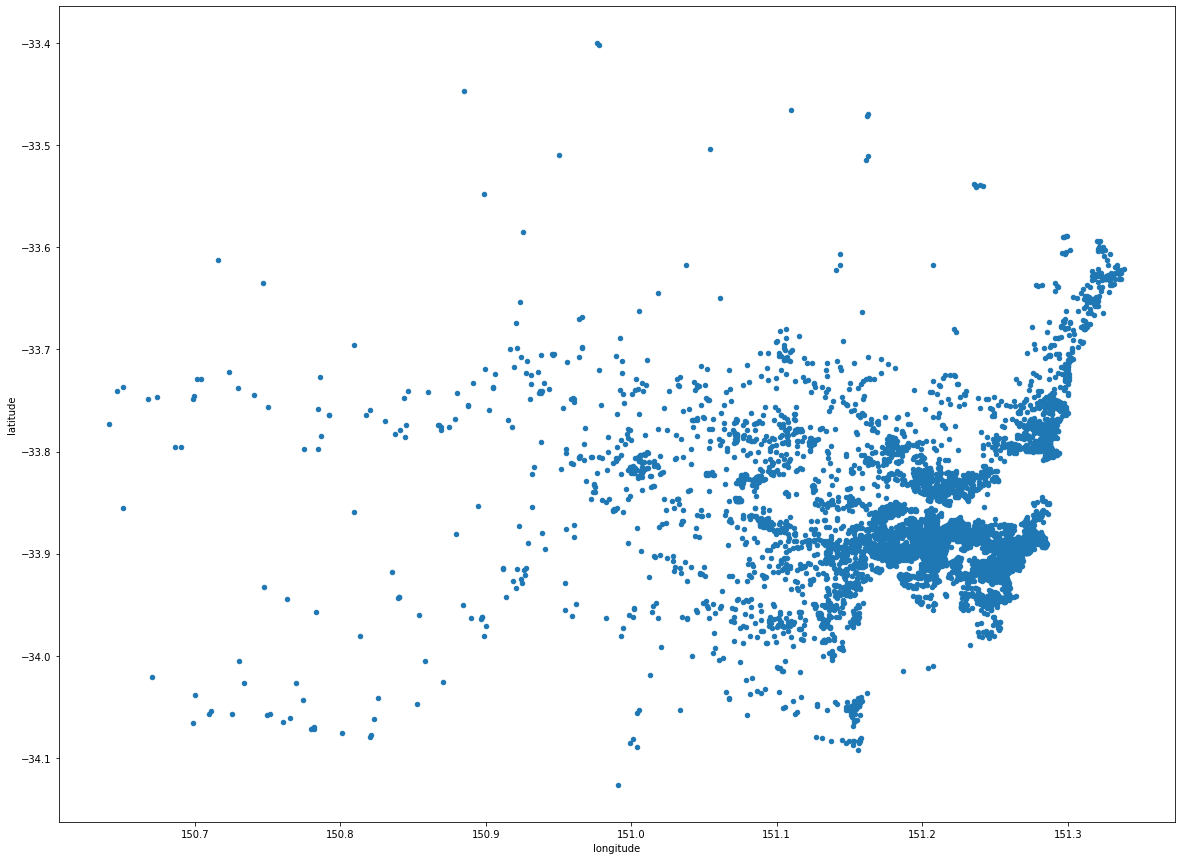

In [5]:
full_df[['latitude','longitude']].plot(x='longitude',y='latitude',kind='scatter',figsize=(20,15))
plt.show()

## DBSCAN

DBSCAN mengelompokan data point berdasarkan kerapatan (density) antara satu data point dengan yang lainnya. Jumlah cluster yang dihasilkan akan secara otomatis ditentukan berdasarkan kerapatan data.

hyperparameter yang dapat ditune antara lain
- eps = mengkonfigurasi seberapa jauh jarak data untuk dapat dikelompokkan dalam satu cluster
- min_samples = mengkonfigurasi seberapa banyak data point yang harus dekat (rapat) untuk dapat dijadikan satu cluster

hasil cluster DBSCAN, akan menghasilkan data point yang berlabel -1 yang maksudnya adalah datapoint tersebut dianggap sebagai noise dan tidak dikelompokan ke dalam cluster manapun.

Kelemahan dari DBSCAN adalah jika datapoint tersebar, tidak akan ada cluster yang dihasilkan walaupun dapat terlihat sebagai satu cluster 

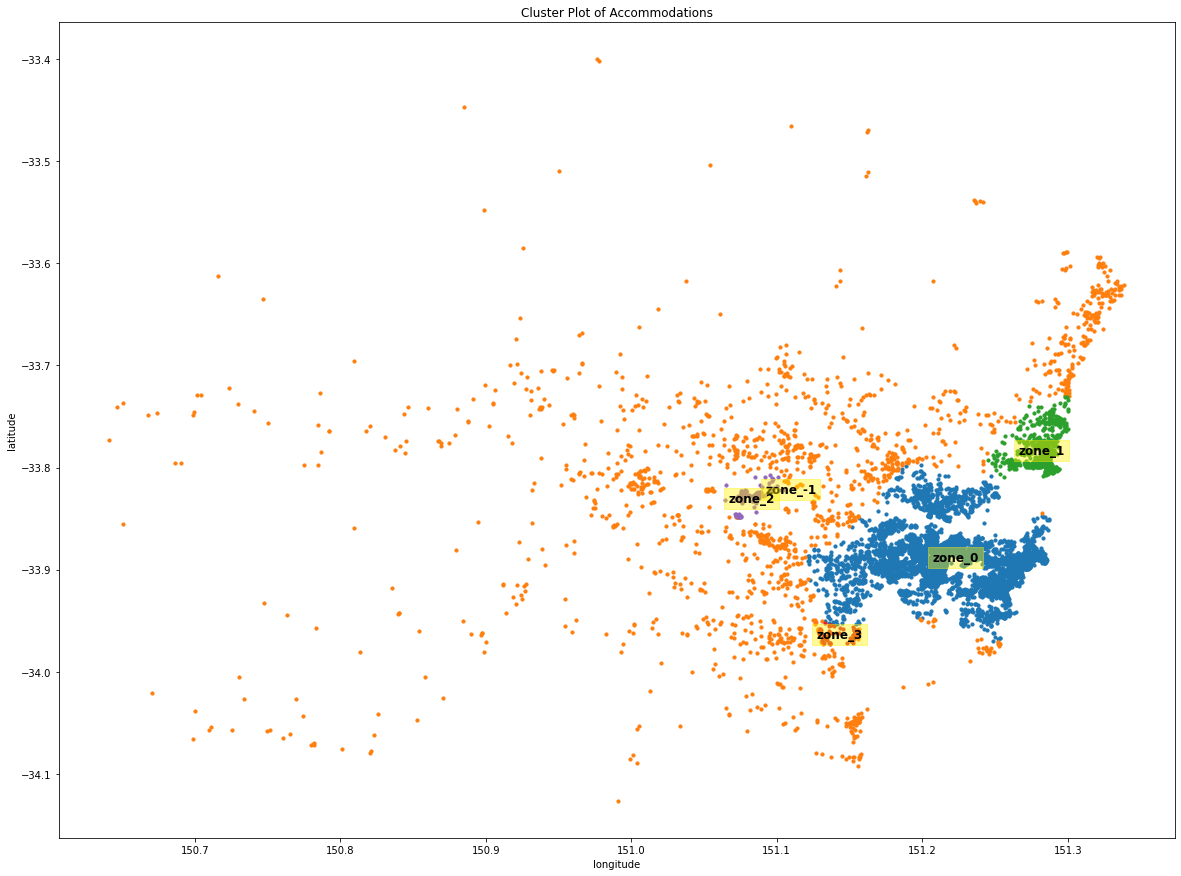

In [6]:
dbtest = DBSCAN(eps=0.02, min_samples=70)
dbtest.fit(X_scaled)
y = dbtest.labels_

plot_zone(full_df, y, labels=True)


## K-Means

K-Means mengelompokkan data point berdasarkan jarak antar data dengan centroid. Inisiasi centroid akan dilakukan secara random dengan jumlah sesuai dengan nilai K. Titik centroid pada satu cluster akan bergeser/diupdate berdasarkan titik mean dari datapoint yang dikelompokan kedalam cluster tersebut.

Proses pengelompokan dan pergeseran titik centroid dilakukan secara iteratif hingga titik centroid tidak ada yang bergeser atau jumlah iterasi maksimal telah terlampaui

kelemahan K-means adalah kesulitan untuk menentukan jumlah K yang paling baik.

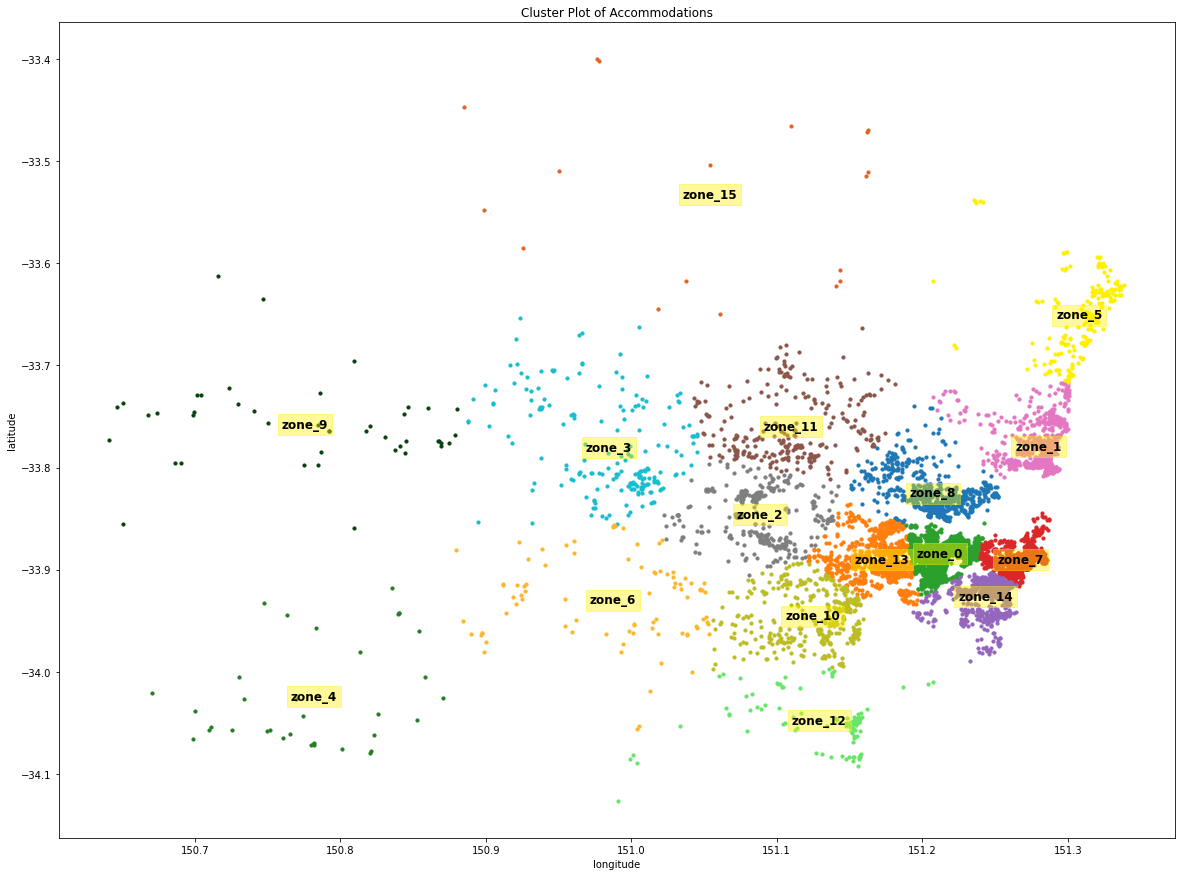

array([[0.333618  , 0.81865999],
       [0.47765474, 0.91581838],
       [0.38557627, 0.6410532 ],
       [0.47604912, 0.49244429],
       [0.14030755, 0.20166322],
       [0.65516607, 0.95603509],
       [0.27062806, 0.49619148],
       [0.32538731, 0.89794292],
       [0.41509123, 0.81165733],
       [0.50786981, 0.19282266],
       [0.24911879, 0.69316075],
       [0.50483763, 0.67179123],
       [0.10833258, 0.69957762],
       [0.32501114, 0.76129687],
       [0.27490479, 0.86370493],
       [0.81801825, 0.59175008]])

In [7]:
ktest = KMeans(n_clusters=16, random_state=42)
ktest.fit(X_scaled)
y = ktest.predict(X_scaled)

plot_zone(full_df, y)

ktest.cluster_centers_

model clustering lainnya dapat dicek pada halaman berikut

https://scikit-learn.org/stable/modules/clustering.html

## Finding the best K for KMeans

### Within-Cluster-Sum of Squared Errors (WSS) approach

WSS pada intinya adalah jumlah pangkat (squared) error dari datapoint yang ada dalam masing-masing cluster. WSS yang kecil akan semakin bagus namun yang dipilih adalah K dimana tingkat peningkatan kualitas clustering mulai mengecil. Jadi titik dimana elbow point pada kurva WSS.

In [8]:
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i,0] - curr_center[0]) ** 2 + (points[i,1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

sse = calculate_WSS(X_scaled, 30)


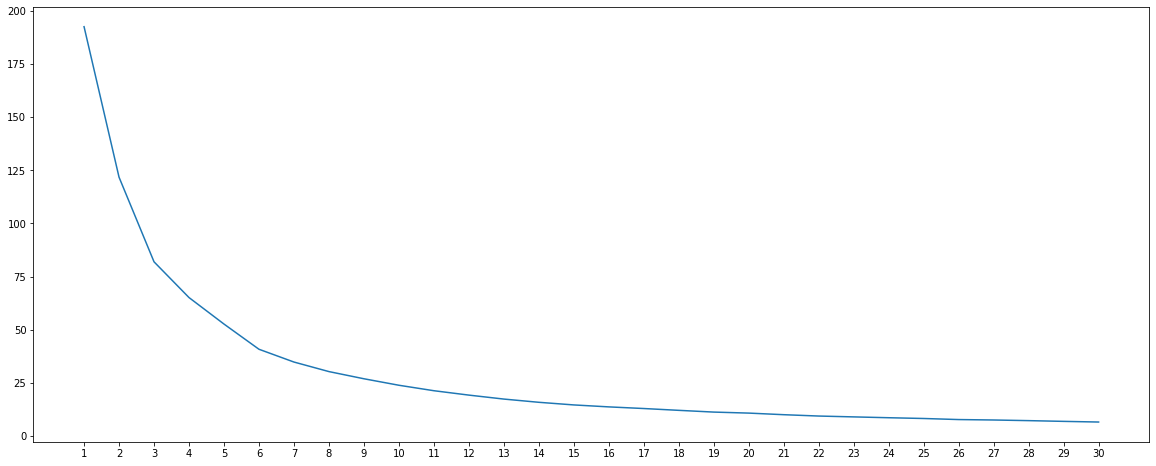

In [9]:
pd.Series(sse).plot(figsize=(20,8))
plt.xticks(range(0, 30), range(1, 31))
plt.show()

Kalau dilihat titik diminishing peningkatan performanya, K optimal ada disekitar angka 8-9

In [10]:
sil = []
kmax = 30

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(X_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(X_scaled, labels, metric = 'euclidean'))

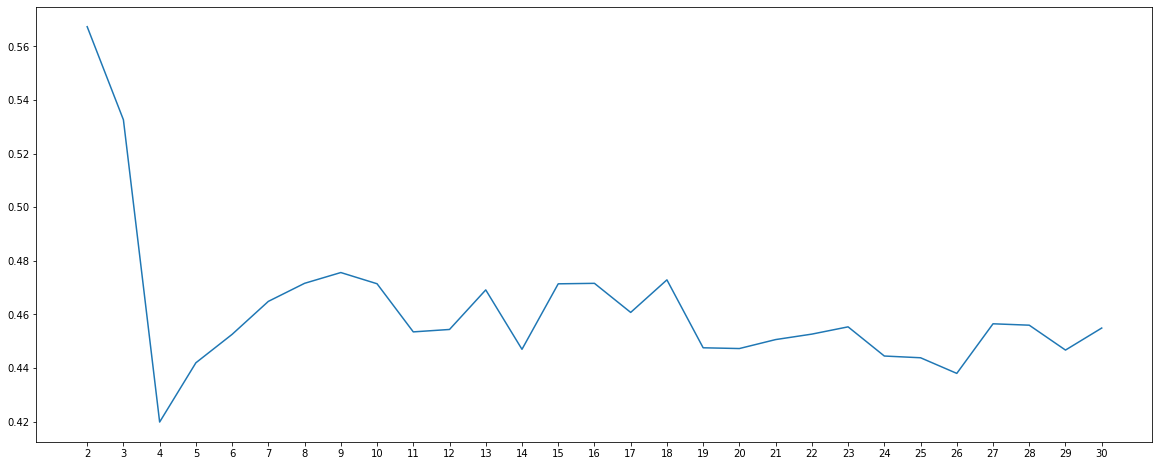

In [11]:
pd.Series(sil).plot(figsize=(20,8))
plt.xticks(range(0,kmax-1), range(2,kmax+1))
plt.show()

Jika dilihat, K=2 atau 3 merupakan jumlah cluster paling optimal. Selanjutnya, nilai optimal ada di titik 9

**Coba**

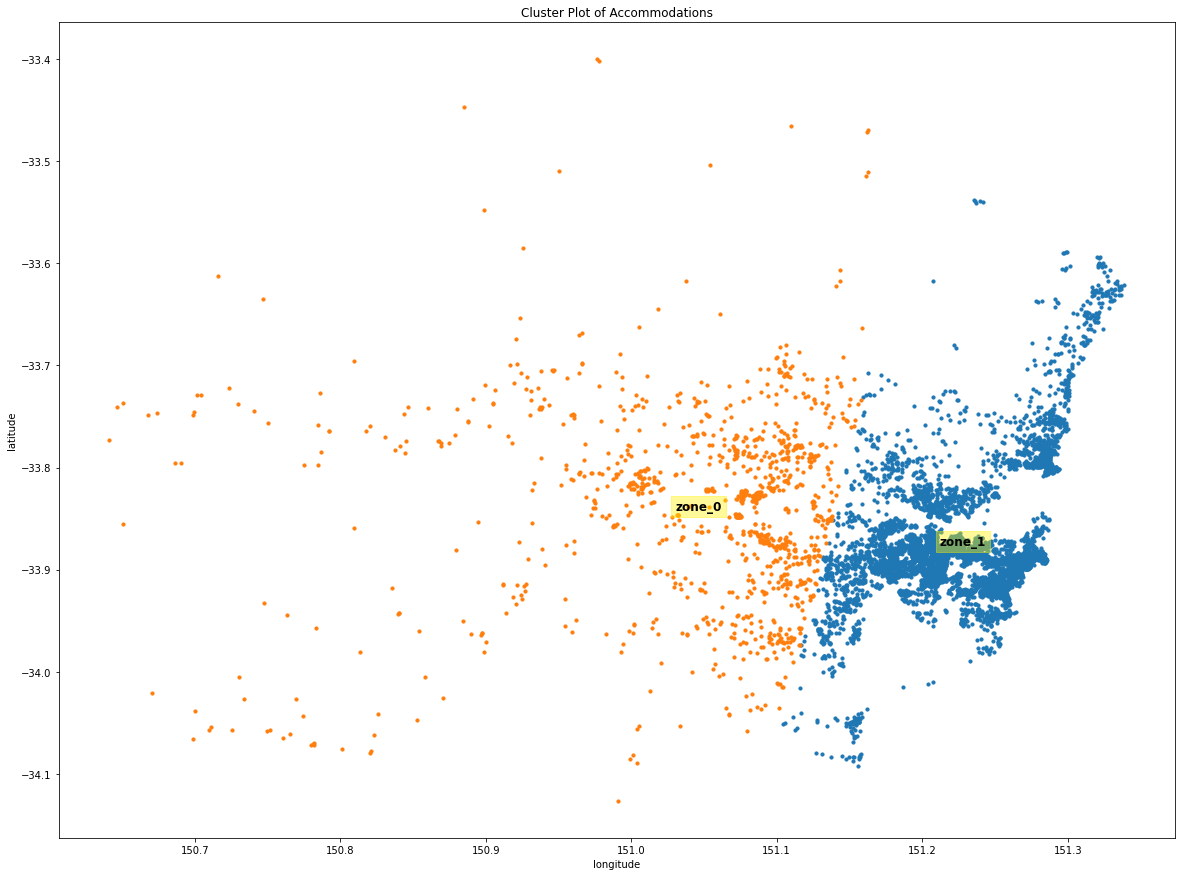

array([[0.39613512, 0.58067823],
       [0.34981634, 0.84120416]])

In [12]:
# K = 2
ktest = KMeans(n_clusters=2, random_state=42)
ktest.fit(X_scaled)
y = ktest.predict(X_scaled)

plot_zone(full_df, y)

ktest.cluster_centers_

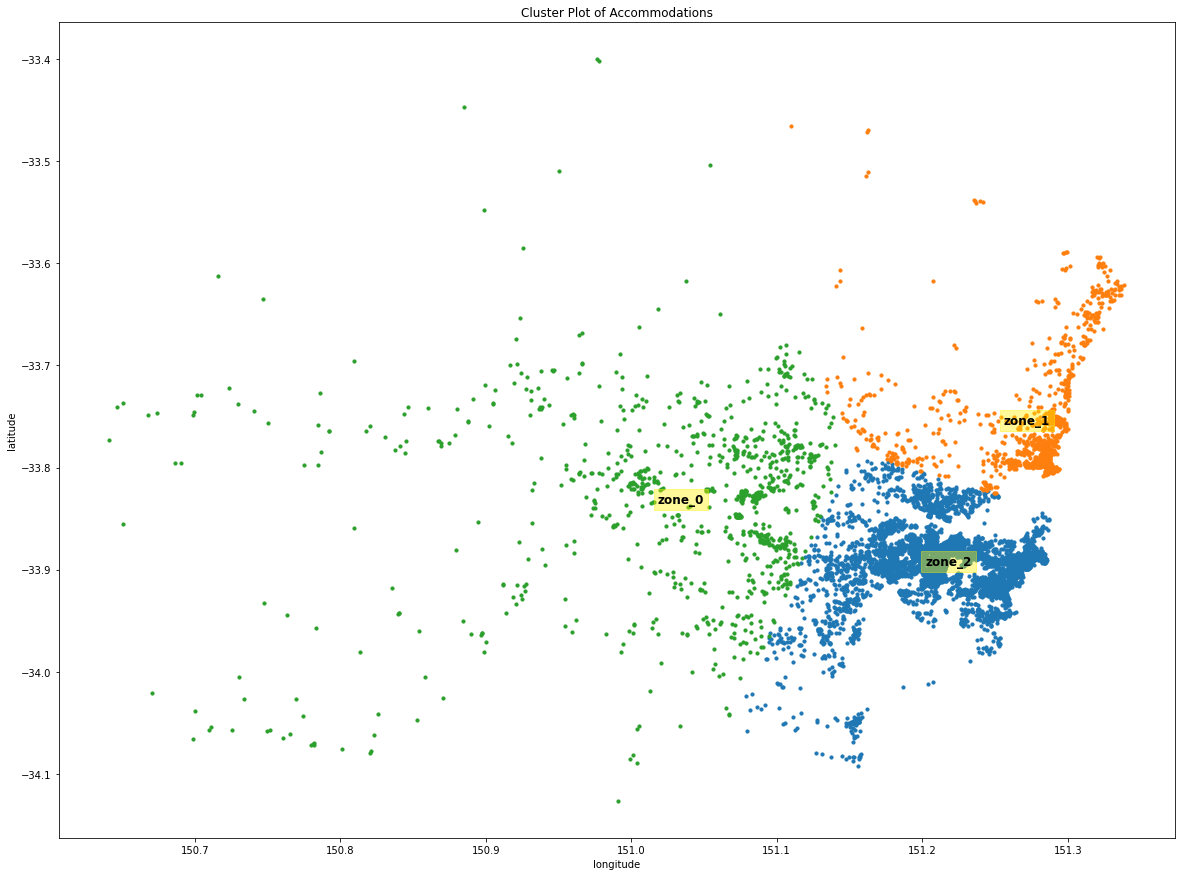

array([[0.406552  , 0.56313361],
       [0.51239479, 0.90447074],
       [0.32261529, 0.82713603]])

In [13]:
# K = 3
ktest = KMeans(n_clusters=3, random_state=42)
ktest.fit(X_scaled)
y = ktest.predict(X_scaled)

plot_zone(full_df, y)

ktest.cluster_centers_

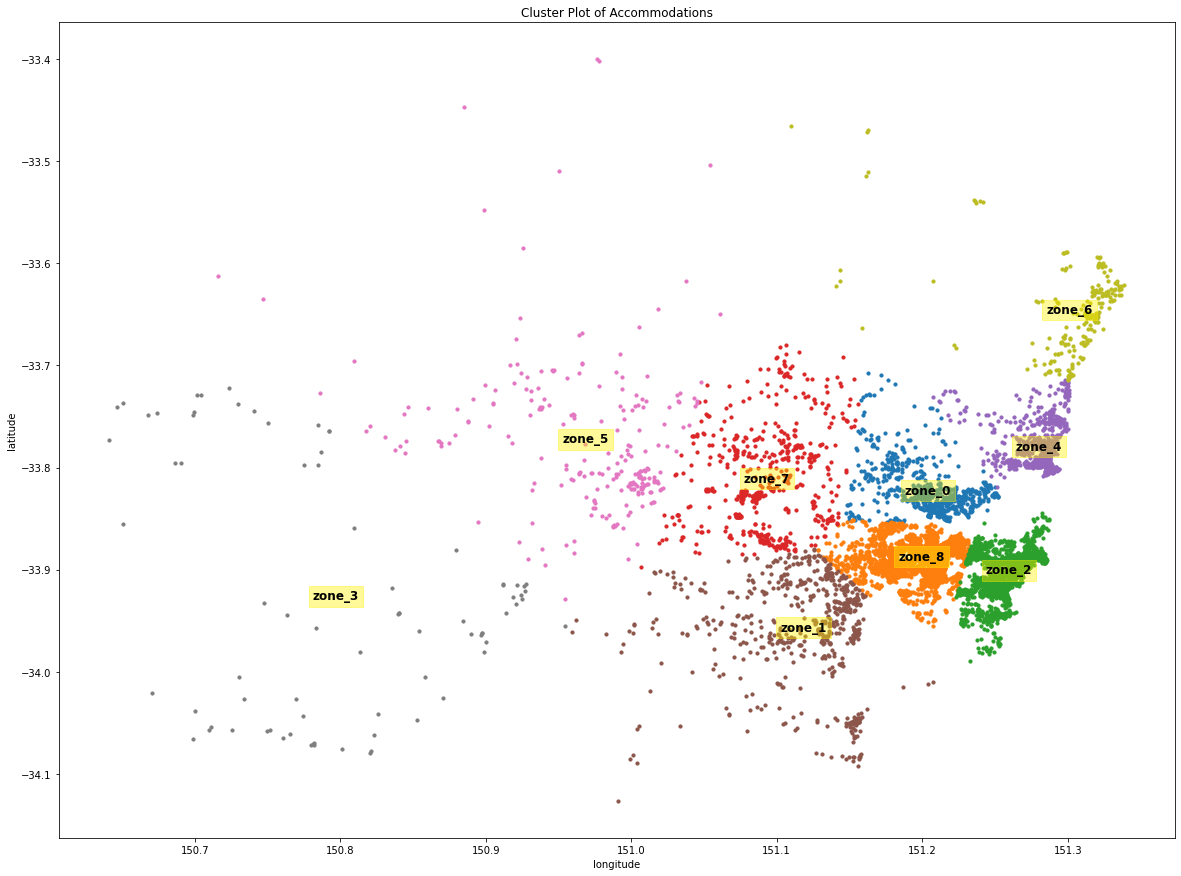

array([[0.4185134 , 0.80640757],
       [0.2336227 , 0.68405368],
       [0.31105761, 0.88663786],
       [0.27596426, 0.22343959],
       [0.47769821, 0.91590506],
       [0.48785029, 0.46888108],
       [0.66201263, 0.9464183 ],
       [0.43510717, 0.64781411],
       [0.32931454, 0.80065669]])

In [14]:
# K = 9
ktest = KMeans(n_clusters=9, random_state=42)
ktest.fit(X_scaled)
y = ktest.predict(X_scaled)

plot_zone(full_df, y)

ktest.cluster_centers_

keputusan terakhir ada pada data analysis. Jika dirasa 2 atau 3 terlalu melimitasi hasil clustering, K=9 adalah pilihan nilai K paling optimal yang dapat diambil karena disupport oleh pendekatan WSS dan nilai optimal berikutnya pada pendekatan silhouete